In [40]:
import sys

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

This notebook is using the pytorch library from 
https://github.com/fastai/fastai
to solve the bone age challenge from 
http://rsnachallenges.cloudapp.net/competitions/4

In this a second model in which we add gender to the model. 

In [41]:
path = "/data/yinterian/bone_age/"

In [42]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

### Looking at the data

In [20]:
from os import listdir
from os.path import join
print(listdir(path))
#print(listdir(join(path, 'boneage-training-dataset')))

['val-color', 'dataset_data_file-test-phase-gender-ground-truth.csv', 'aux', 'train_target.zip', 'sample_submission.zip', 'boneage-validation-dataset-2', 'boneage-test-dataset', 'submission_sep_22_v2.csv', 'boneage-validation-dataset-1', 'submission_sep_22.zip', 'models', 'test-color', 'results.csv', 'submission-rand.csv', 'document.txt', 'boneage-validation-dataset-2.zip', 'tmp', 'train.csv', 'boneage-validation-dataset-1.zip', 'boneage-training-dataset.zip', 'boneage-test-dataset.zip', 'description.txt', 'training-color', 'gender-val.csv', 'submission_sep_22.csv', 'sample_submission', 'submission_sep_22_v2.zip', 'boneage-training-dataset', 'train2.csv']


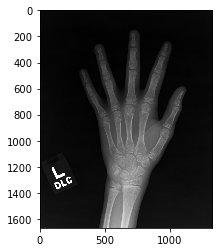

In [12]:
onebone = join(path, 'boneage-training-dataset/9977.png')
img = mpimg.imread(onebone)
plt.imshow(img, cmap='gray')

In [13]:
img.shape

(1668, 1323)

## Model from scratch

In [105]:
class ConvWithMeta(nn.Module):
    def __init__(self):
        super(ConvWithMeta, self).__init__()
        resnet_layers = list(resnet34(True).children())[:8]
        self.features = nn.Sequential(*resnet_layers)
        for param in self.features.parameters():
            param.requires_grad = False
        self.bns = nn.ModuleList([nn.BatchNorm1d(513), nn.BatchNorm1d(512)])
        self.lins = nn.ModuleList([nn.Linear(513,512), nn.Linear(512, 1)])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.fc_model = nn.Sequential(*self.fc_layers()).cuda()
        
    def fc_layers(self):
        return [self.bns[0], nn.Dropout(0.2), self.lins[0], nn.ReLU(), 
                self.bns[1], nn.Dropout(0.2), self.lins[1]] 
        
    def forward(self, x1, x2):
        x1 = self.features(x1)
        x1 = nn.AdaptiveMaxPool2d((1,1))(x1)
        x1 = x1.view(x1.size(0), -1)
        x = torch.cat([x1, x2], 1)
        x = self.fc_model(x)
        return x

In [106]:
class MetaModel(BasicModel):
    def get_layer_groups(self):
        m=self.model
        return [children(m.features)[:6], children(m.features)[6:],children(m.lins)+children(m.bns)]

In [107]:
class MetaLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.l1_loss

## Dataset

In [108]:
class MetaDataset(BaseDataset):
    """ Dataset where x=(x1,x2) where x1 is an image.
    """
    def __init__(self, fnames, x2, y, transform, path):
        self.path,self.fnames,self.y,self.x2 = path,fnames,y,x2
        assert(len(fnames)==len(y))
        super().__init__(transform)

    def __getitem__(self, idx):
        """ This function should return a list.
        """
        x1, x2 = self.get_x(idx)
        y = self.get_y(idx)
        return self.get(self.transform, (x1, x2), y)
    
    def __len__(self): return len(self.y)
    
    def get_x(self, i):
        im = PIL.Image.open(os.path.join(self.path, self.fnames[i])).convert('RGB')
        x2 = np.expand_dims(self.x2[i], axis=1)
        return np.array(im, dtype=np.float32)/255., x2
    
    def get_n(self): return len(self.y)
    def get_y(self, i): return self.y[i]
    
    def get(self, tfm, x, y):
        x1, x2 = x
        if tfm is None:
            return [x1, x2, y] 
        x1,y = tfm(x1,y)
        return [x1, x2, y]
    
    def get_c(self): return 1
    
    def get_sz(self): return self.transform.sz

In [109]:
def csv_source2(folder, csv_file, skip_header=True, suffix='', continuous=False):
    """ Parsing file.
    
    This file has the following format (file_id,y,x2)
       id,boneage,male
       1377,180,False
       1378,12,False
       1379,94,False
    """
    skip = 1 if skip_header else 0
    print(csv_file)
    csv_lines = [o.strip().split(',') for o in open(csv_file)][skip:]
    csv_labels = {a[0]: (a[1], int(a[2] == "True")) for a in csv_lines}
    fnames = sorted(csv_labels.keys())
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
    y = np.array([csv_labels[i][0] for i in fnames]).astype(np.float32)
    x2 = np.array([csv_labels[i][1] for i in fnames]).astype(np.float32)
    return full_names, x2, y

In [110]:
class ModelMetaData(ImageClassifierData):
    
    @classmethod
    def get_ds(self, fn, trn, val, tfms, path, test=None):
        res = [
            fn(trn[0], trn[1], trn[2], tfms[0], path), # train
            fn(val[0], val[1], val[2], tfms[1], path), # val
            fn(trn[0], trn[1], trn[2], tfms[1], path), # fix
            fn(val[0], val[1], val[2], tfms[0], path)  # aug
        ]
        if test:
            test_lbls = np.zeros((len(test),1))
            res += [
                fn(test, test_lbls, tfms[1], path), # test
                fn(test, test_lbls, tfms[0], path)  # test_aug
            ]
        else: res += [None,None]
        return res
    
    @classmethod
    def from_csv(self, path, folder, csv_fname, bs=64, tfms=(None,None),val_idxs=None, 
                 suffix='', test_name=None, skip_header=True, num_workers=4):
        fnames,x2,y = csv_source2(folder, csv_fname, skip_header, suffix)
        ((val_fnames, trn_fnames), (val_x2, trn_x2), (val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), x2, y)

        test_fnames = read_dir(path, test_name) if test_name else None
        datasets = self.get_ds(MetaDataset, (trn_fnames,trn_x2,trn_y), (val_fnames,val_x2,val_y),
                               tfms=tfms, path=path)
        return self(path, datasets, bs, num_workers, classes=1)
    def get_learner(self):
        model = ConvWithMeta()
        return MetaLearner(self, MetaModel(model.cuda()), opt_fn=optim.Adam)

### Dataset definition

In [111]:
bs=64; sz=350
f_model = resnet34
path = "/data/yinterian/bone_age/"
img_folder = "training-color"
test = "test-color"
csv_fname = os.path.join(path, "train.csv")
csv_file = csv_fname 

In [112]:
# these are the validation indices
seed = 3
np.random.seed(seed)
n = 12611
m = int(n*0.2)
val_idxs = np.random.choice(n, m, replace=False)
val_idxs

array([6067,  466, 5556, ..., 9525, 2740,  810])

In [113]:
# transforms_side_on, aug_tfms=transforms_basic
#test_name="test-color"
tfms = tfms_from_model(f_model, sz)
data = ModelMetaData.from_csv(path, img_folder, csv_fname, bs, tfms, val_idxs, suffix=".png")

/data/yinterian/bone_age/train.csv


In [115]:
learner = data.get_learner()
learner.lr_find()

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home


 78%|███████▊  | 123/158 [02:20<00:35,  1.02s/it, loss=196] 

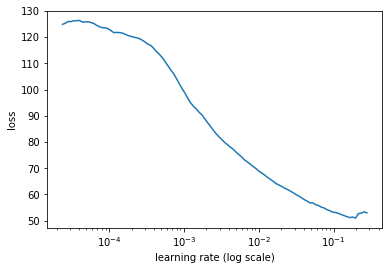

In [117]:
learner.sched.plot()

In [ ]:
learner.fit(1e-2, 4)

                                                           
                                                           
                                                           
                                                           
  0%|          | 0/158 [00:00<?, ?it/s]
                                                           
                                                           


/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home

[  0.       24.61157  19.63751]
  0%|          | 0/158 [00:00<?, ?it/s]

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home

[  1.       24.64034  19.60417]
  0%|          | 0/158 [00:00<?, ?it/s]

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home

[  2.       21.25816  17.29447]
  0%|          | 0/158 [00:00<?, ?it/s]

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home

## Debugging your model

In [102]:
x1, x2, y = next(iter(data.trn_dl))

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [98]:
m = ConvWithMeta().cuda()
# have to specify parameters here
opt=optim.Adam(m.fc_model.parameters(), lr =0.1)
loss = F.l1_loss

In [99]:
fit(m, data, epochs=1, crit=loss, opt=opt)

  0%|          | 0/158 [00:00<?, ?it/s]

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home

torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
  1%|          | 1/158 [00:06<16:41,  6.38s/it, loss=130]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
  1%|▏         | 2/158 [00:06<11:48,  4.54s/it, loss=1.06e+03]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
  2%|▏         | 3/158 [00:06<08:24,  3.25s/it, loss=737]     torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
  3%|▎         | 4/158 [00:07<06:01,  2.35s/it, loss=589]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
  3%|▎         | 5/158 [00:11<07:44,  3.04s/it, loss=495]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
  4%|▍         | 6/158 [00:12<05:38,  2.22s/it, loss=423]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
  4%|▍         | 7/158 [00:12<04:05,  1.63s/it, loss=366]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
  5%|▌         | 8/158 [00:12<03:02,  1.21s/it, loss=326]torch.Size([64, 512]) 

 42%|████▏     | 67/158 [01:18<01:20,  1.13it/s, loss=53.7]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 43%|████▎     | 68/158 [01:19<01:09,  1.30it/s, loss=53]  torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 44%|████▎     | 69/158 [01:22<02:11,  1.48s/it, loss=52.5]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 44%|████▍     | 70/158 [01:22<01:37,  1.11s/it, loss=51.8]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 45%|████▍     | 71/158 [01:23<01:27,  1.00s/it, loss=51.3]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 46%|████▌     | 72/158 [01:23<01:06,  1.29it/s, loss=50.7]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 46%|████▌     | 73/158 [01:26<02:10,  1.53s/it, loss=50.2]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 47%|████▋     | 74/158 [01:27<01:40,  1.19s/it, loss=49.7]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 47%|████▋     |

 84%|████████▍ | 133/158 [02:33<00:36,  1.48s/it, loss=33.3]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 85%|████████▍ | 134/158 [02:34<00:29,  1.25s/it, loss=33.1]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 85%|████████▌ | 135/158 [02:34<00:22,  1.04it/s, loss=32.9]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 86%|████████▌ | 136/158 [02:34<00:16,  1.30it/s, loss=32.8]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 87%|████████▋ | 137/158 [02:38<00:31,  1.51s/it, loss=32.6]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 87%|████████▋ | 138/158 [02:38<00:23,  1.17s/it, loss=32.4]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 88%|████████▊ | 139/158 [02:38<00:17,  1.12it/s, loss=32.4]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 89%|████████▊ | 140/158 [02:39<00:15,  1.17it/s, loss=32.3]torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
 89%|███

/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home/yinterian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/home

torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1])
torch.Size([64, 513])
torch.Size([64, 512]) torch.Size([64, 1]